In [43]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    def _optimize(self, X, target):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, target)
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

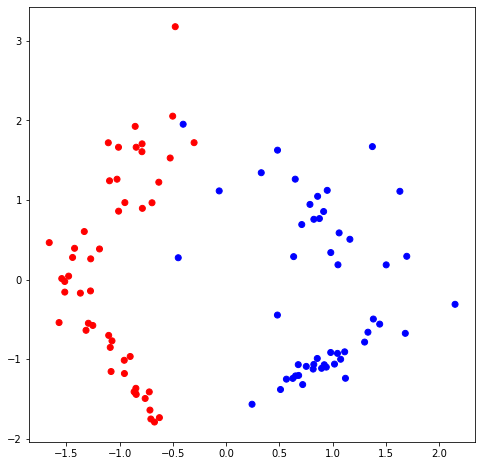

In [3]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [5]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [11]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.32398168 0.01226158]]
Точность на обучающей выборке: 97.143
Точность на тестовой выборке: 96.667


Матрица ошибок

In [13]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [14]:
cofusion_fixed=confusion(mod.predict(X_test), y_test)
sensitivity=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FN'])
specificity=cofusion_fixed['TN']/(cofusion_fixed['TN']+cofusion_fixed['FP'])
balanced_accuracy=(sensitivity+specificity)/2
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность {sensitivity},"+
      f"специфичность {specificity}, сбалансированную точность {balanced_accuracy}")

Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность 0.9375,специфичность 1.0, сбалансированную точность 0.96875


In [15]:
precision=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FP'])
recall=sensitivity
f1_score=2*precision*recall/(precision+recall)
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: точность {precision},"+
      f"полноту {recall}, f1-скор {f1_score}")

Для порога по вероятности 0.5 на тестовой выборке имеем: точность 1.0,полноту 0.9375, f1-скор 0.967741935483871


In [16]:
mod=logistic_regression()
mod.fit(X_train, y_train)
proba=np.unique(mod.predict_proba(X_test))

In [19]:
conf_mat_list=[]
for p in proba[::-1]:
        conf_mat_list.append(confusion(mod.predict(X_test, p), y_test))

In [20]:
num_pos=np.sum(y_test)
num_neg=len(y_test)-num_pos

In [28]:
TPR_mod=np.concatenate([np.array([m['TP'] for m in conf_mat_list])/num_pos, [1]])
FPR_mod=np.concatenate([np.array([m['FP'] for m in conf_mat_list])/(len(y_test)-num_pos), [1]])

In [29]:
TPR_mod

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       0.9375, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ])

In [30]:
FPR_mod

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07142857, 0.07142857, 0.14285714, 0.21428571,
       0.28571429, 0.35714286, 0.42857143, 0.5       , 0.57142857,
       0.64285714, 0.71428571, 0.78571429, 0.85714286, 0.92857143,
       1.        ])

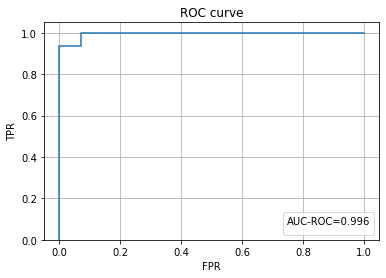

In [32]:
AUC_ROC = np.sum((FPR_mod[1:]-FPR_mod[:-1])*(TPR_mod[1:]+TPR_mod[:-1])/2)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR_mod, TPR_mod)

In [41]:
precision_mod=np.concatenate([np.array([m['TP']/(m['TP']+m['FP']) for m in conf_mat_list[1:]]), [num_pos/len(y_test)]])
recall_mod = TPR_mod

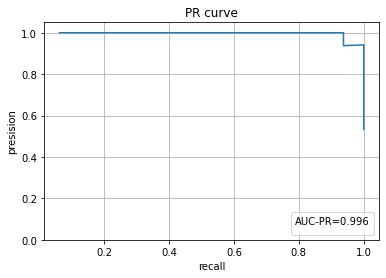

In [42]:
AUC_PR = np.sum(precision_mod*(recall_mod[1:]-recall_mod[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall_mod[1:], precision_mod)